In [1]:
#Neural netowrk classification with pytorch

In [2]:
#making a toy dataset for classification

In [3]:
from sklearn.datasets import make_circles
n_samples=1000

X,y=make_circles(n_samples,noise=0.03,random_state=42)
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:{X[:5]}\n")
print(f"First 5 samples of y:{y[:5]}\n")

First 5 samples of X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y:[1 1 1 1 0]



In [5]:
#Make dataframe of circle data
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


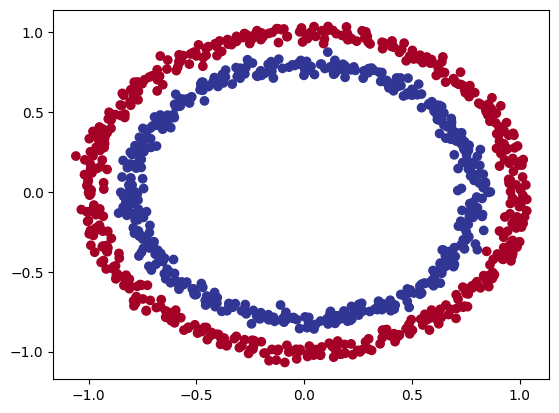

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [7]:
#check input and output shapes
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
X_sample=X[0]
y_sample=y[0]
print(f"Values of one sample for X: {X_sample} and the same for y: {y_sample}")
print(f"Shpaes of one sample for x:{X_sample.shape} and the same for y: {y_sample.shape}")

Values of one sample for X: [0.75424625 0.23148074] and the same for y: 1
Shpaes of one sample for x:(2,) and the same for y: ()


In [9]:
import torch
print(torch.__version__)

2.0.1+cu118


In [10]:
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
X.dtype,y.dtype

(torch.float32, torch.float32)

In [12]:
#split the data into training and testing datasets
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

In [13]:
#Building a model
import torch
from torch import nn

#device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
#construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2.Create 2 linear layers capable of handling data
    self.layers_1=nn.Linear(in_features=2,out_features=5)#taking 2 features and upscaling it to 5 features
    self.layers_2=nn.Linear(in_features=5,out_features=1)

    #3.define forward pass
    def forward(self,x):
      return self.layer_2(self.layer_1(x))
#4.instantiate a model class
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layers_1): Linear(in_features=2, out_features=5, bias=True)
  (layers_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
#replicating above model using nn.Sequential()
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6831,  0.3654],
                      [ 0.1844,  0.3424],
                      [ 0.3541, -0.0639],
                      [-0.5476, -0.5182],
                      [ 0.6973,  0.6890]])),
             ('0.bias', tensor([ 0.5729, -0.6639,  0.0868,  0.1940, -0.4073])),
             ('1.weight',
              tensor([[ 0.0011, -0.4188,  0.1062,  0.0551, -0.0123]])),
             ('1.bias', tensor([-0.1817]))])

In [17]:
#make predictions
with torch.inference_mode():
  untrained_preds=model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)},Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)},Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}\n")
print(f"\nFirst 10 labels:{y_test[:10]}\n")

Length of predictions: 200,Shape: torch.Size([200, 1])
Length of test samples: 200,Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.]])


First 10 labels:tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])



In [18]:
#setup loss function and optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [19]:
#calculate accuracy
def accuracy(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  accuracy=(correct/len(y_pred))*100
  return accuracy

In [20]:
#view first 5 ouputs of the forward pass on test data
model_0.eval()
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))[:5]
  y_logits

In [21]:
#Use sigmoid activation function on logits to turn them into prediction probabilities
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5060],
        [0.4853],
        [0.5588],
        [0.4910],
        [0.5570]])

In [22]:
#find predicted labels
y_preds=torch.round(y_pred_probs)

#full
y_pred_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [23]:
torch.manual_seed(42)

#set the number of epochs
epochs=100

#put the data on target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

#Build on training and evaluation loop
for epoch in range(epochs):
  #training
  model_0.train()

  #1.Forward pass
  y_logits=model_0(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  #2.calculate loss and accuracy
  loss=loss_fn(y_logits,y_train)#nn.BCEWithLogitsLoss expects inputs as logits
  acc=accuracy(y_true=y_train,y_pred=y_preds)

  #3.optimizer zero grad
  optimizer.zero_grad()

  #4.loss backward
  loss.backward()

  #5.optimizer step(gradient descent)
  optimizer.step()

  #testing
  model_0.eval()

  with torch.inference_mode():
    #1.forward pass
    test_logits=model_0(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))

    #2.calculate test loss/accuracy
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_preds)

    #print out stuff
    if epoch%10==0:
      print(f"Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} |Test loss: {test_loss:.5f}, Test Accuracy:{test_acc:.5f}")

Epoch: 0 | loss: 0.69836, Acc: 53.25 |Test loss: 0.69189, Test Accuracy:54.00000
Epoch: 10 | loss: 0.69560, Acc: 51.00 |Test loss: 0.69117, Test Accuracy:55.00000
Epoch: 20 | loss: 0.69459, Acc: 50.25 |Test loss: 0.69136, Test Accuracy:53.00000
Epoch: 30 | loss: 0.69414, Acc: 50.00 |Test loss: 0.69171, Test Accuracy:53.50000
Epoch: 40 | loss: 0.69387, Acc: 49.25 |Test loss: 0.69203, Test Accuracy:52.00000
Epoch: 50 | loss: 0.69370, Acc: 48.75 |Test loss: 0.69230, Test Accuracy:52.00000
Epoch: 60 | loss: 0.69356, Acc: 49.25 |Test loss: 0.69254, Test Accuracy:50.00000
Epoch: 70 | loss: 0.69345, Acc: 49.50 |Test loss: 0.69275, Test Accuracy:50.50000
Epoch: 80 | loss: 0.69337, Acc: 50.00 |Test loss: 0.69293, Test Accuracy:48.00000
Epoch: 90 | loss: 0.69330, Acc: 50.62 |Test loss: 0.69310, Test Accuracy:46.00000


In [24]:
#Make predictions and evalaute the model
import requests
from pathlib import Path

#Download helper function
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists,skipping download")
else:
  print("Download helper_functions.py")
  requests=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(requests.content)

Download helper_functions.py


In [25]:
from helper_functions import plot_predictions,plot_decision_boundary

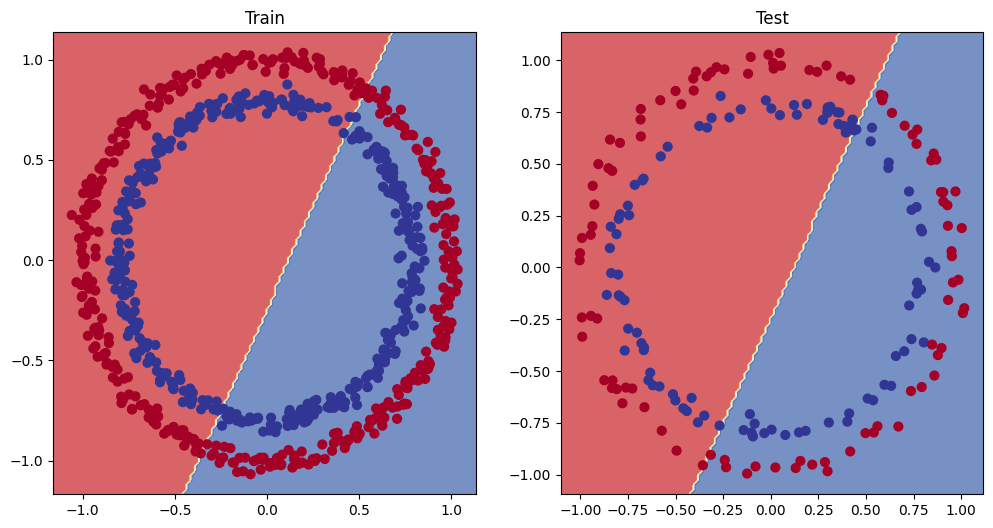

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [27]:
#lets improve model by adding more hidden units,layers and also increase number of epochs

In [28]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    z=self.layer_1(x)
    z=self.layer_2(z)
    z=self.layer_3(z)
    return z#writing in one line itself is better thoughbecause it leverages speedup

In [29]:
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
#loss function
loss_fn=nn.BCEWithLogitsLoss()

#opitmizer
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [31]:
torch.manual_seed(42)

epochs=1000

#put data on the target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits=model_1(X_test).squeeze()

    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_test,test_pred)

  if epoch%100==0:
      print(f"Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} |Test loss: {test_loss:.5f}, Test Accuracy:{test_acc:.5f}")




Epoch: 0 | loss: 0.69396, Acc: 50.88 |Test loss: 0.69261, Test Accuracy:51.00000
Epoch: 100 | loss: 0.69305, Acc: 50.38 |Test loss: 0.69379, Test Accuracy:48.00000
Epoch: 200 | loss: 0.69299, Acc: 51.12 |Test loss: 0.69437, Test Accuracy:46.00000
Epoch: 300 | loss: 0.69298, Acc: 51.62 |Test loss: 0.69458, Test Accuracy:45.00000
Epoch: 400 | loss: 0.69298, Acc: 51.12 |Test loss: 0.69465, Test Accuracy:46.00000
Epoch: 500 | loss: 0.69298, Acc: 51.00 |Test loss: 0.69467, Test Accuracy:46.00000
Epoch: 600 | loss: 0.69298, Acc: 51.00 |Test loss: 0.69468, Test Accuracy:46.00000
Epoch: 700 | loss: 0.69298, Acc: 51.00 |Test loss: 0.69468, Test Accuracy:46.00000
Epoch: 800 | loss: 0.69298, Acc: 51.00 |Test loss: 0.69468, Test Accuracy:46.00000
Epoch: 900 | loss: 0.69298, Acc: 51.00 |Test loss: 0.69468, Test Accuracy:46.00000


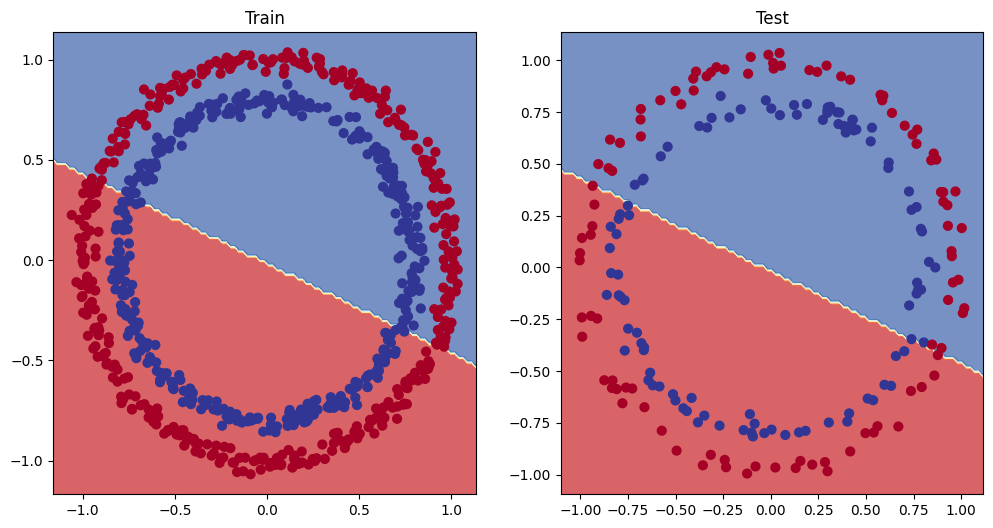

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

In [33]:
#Preparing data to see if our model works on a straight line dataset
weight=0.7
bias=0.3
start=0
end=1
step=0.01

#create data
X_regression=torch.arange(start,end,step).unsqueeze(dim=1)
y_regression=weight*X_regression+bias

print(len(X_regression))
print(len(y_regression))

100
100


In [34]:
#create train and test splits
train_split=int(0.8*len(X_regression))
X_train_regression,y_train_regression=X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression=X_regression[train_split:],y_regression[train_split:]

len(X_train_regression),len(X_test_regression),len(X_test_regression),len(y_test_regression)

(80, 20, 20, 20)

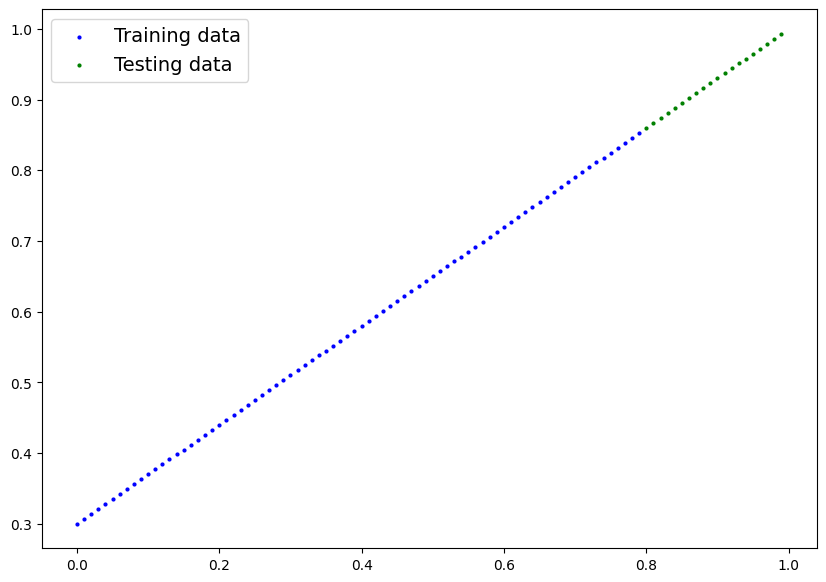

In [35]:
plot_predictions(X_train_regression,y_train_regression,X_test_regression,y_test_regression)

In [36]:
#Adjust model_1 to fit straight line data
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
#define loss and optimizer function
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [38]:
#train the model
torch.manual_seed(42)

epochs=1000

X_train_regression,y_train_regression=X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression=X_test_regression.to(device),y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred=model_2(X_train_regression)

  loss=loss_fn(y_pred,y_train_regression)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_pred=model_2(X_test_regression)

    test_loss=loss_fn(test_pred,y_test_regression)

  if epoch%100==0:
    print(f"Epoch: {epoch} | loss: {loss:.5f} |Test loss: {test_loss:.5f}")

Epoch: 0 | loss: 0.75986 |Test loss: 0.91103
Epoch: 100 | loss: 0.02858 |Test loss: 0.00081
Epoch: 200 | loss: 0.02533 |Test loss: 0.00209
Epoch: 300 | loss: 0.02137 |Test loss: 0.00305
Epoch: 400 | loss: 0.01964 |Test loss: 0.00341
Epoch: 500 | loss: 0.01940 |Test loss: 0.00387
Epoch: 600 | loss: 0.01903 |Test loss: 0.00379
Epoch: 700 | loss: 0.01878 |Test loss: 0.00381
Epoch: 800 | loss: 0.01840 |Test loss: 0.00329
Epoch: 900 | loss: 0.01798 |Test loss: 0.00360


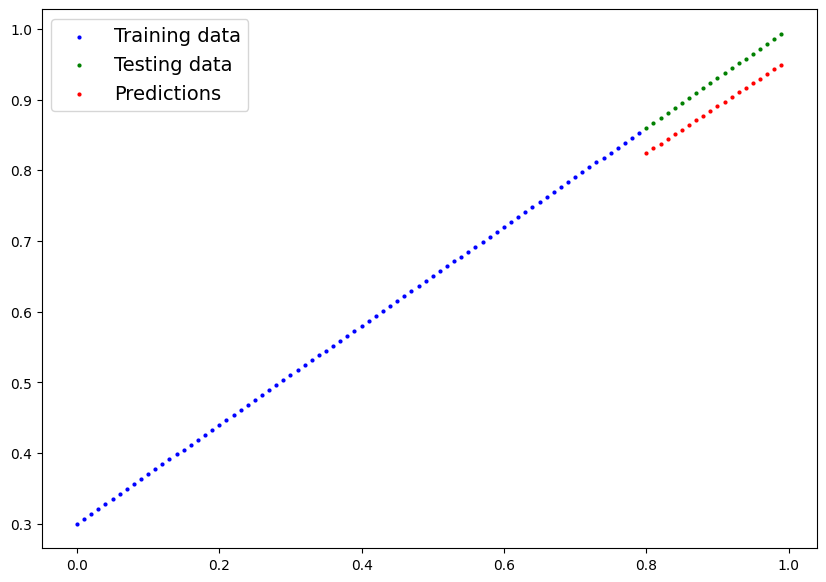

In [45]:
#evaluating and making predictions on model
model_2.eval()
with torch.inference_mode():
  y_pred=model_2(X_test_regression)

  loss=loss_fn(y_pred,y_test_regression)

  plot_predictions(train_data=X_train_regression.cpu(),
                   train_labels=y_train_regression.cpu(),
                   test_data=X_test_regression.cpu(),
                   test_labels=y_test_regression.cpu(),
                   predictions=y_pred.cpu())


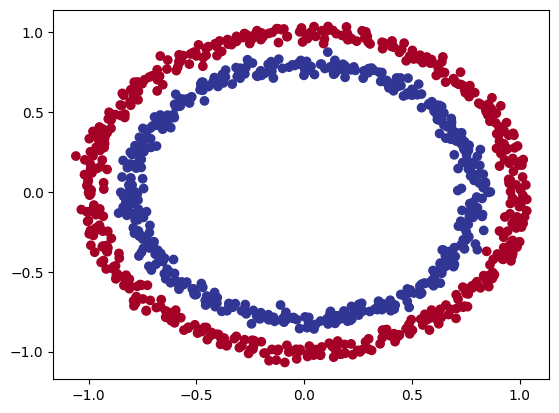

In [40]:
#Non Linear data
from sklearn.datasets import make_circles
n_samples=1000

X,y=make_circles(n_samples,noise=0.03,random_state=42)
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [41]:
import torch
from sklearn.model_selection import train_test_split
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [42]:
#building model with non linear functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))
model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
#setup loss and optimizer functions
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_3.parameters(),lr=0.01)

In [55]:
torch.manual_seed(42)

#set the number of epochs
epochs=100

#put the data on target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

#Build on training and evaluation loop
for epoch in range(epochs):
  #training
  model_3.train()

  #1.Forward pass
  y_logits=model_3(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  #2.calculate loss and accuracy
  loss=loss_fn(y_logits,y_train)#nn.BCEWithLogitsLoss expects inputs as logits
  acc=accuracy(y_true=y_train,y_pred=y_preds)

  #3.optimizer zero grad
  optimizer.zero_grad()

  #4.loss backward
  loss.backward()

  #5.optimizer step(gradient descent)
  optimizer.step()

  #testing
  model_3.eval()

  with torch.inference_mode():
    #1.forward pass
    test_logits=model_3(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))

    #2.calculate test loss/accuracy
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_preds)

    #print out stuff
    if epoch%10==0:
      print(f"Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} |Test loss: {test_loss:.5f}, Test Accuracy:{test_acc:.5f}")

Epoch: 0 | loss: 0.63849, Acc: 79.12 |Test loss: 0.64912, Test Accuracy:76.00000
Epoch: 10 | loss: 0.63823, Acc: 79.12 |Test loss: 0.64894, Test Accuracy:76.00000
Epoch: 20 | loss: 0.63798, Acc: 79.62 |Test loss: 0.64875, Test Accuracy:76.00000
Epoch: 30 | loss: 0.63772, Acc: 79.75 |Test loss: 0.64856, Test Accuracy:76.50000
Epoch: 40 | loss: 0.63746, Acc: 79.88 |Test loss: 0.64837, Test Accuracy:76.50000
Epoch: 50 | loss: 0.63721, Acc: 79.88 |Test loss: 0.64818, Test Accuracy:76.50000
Epoch: 60 | loss: 0.63695, Acc: 80.38 |Test loss: 0.64799, Test Accuracy:77.50000
Epoch: 70 | loss: 0.63669, Acc: 80.62 |Test loss: 0.64779, Test Accuracy:78.50000
Epoch: 80 | loss: 0.63644, Acc: 80.75 |Test loss: 0.64760, Test Accuracy:79.00000
Epoch: 90 | loss: 0.63618, Acc: 80.75 |Test loss: 0.64741, Test Accuracy:78.50000


In [56]:
#evaluating a non linear function
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:5],y_test[:5]

(tensor([1., 1., 1., 1., 1.]), tensor([1., 0., 1., 0., 1.]))

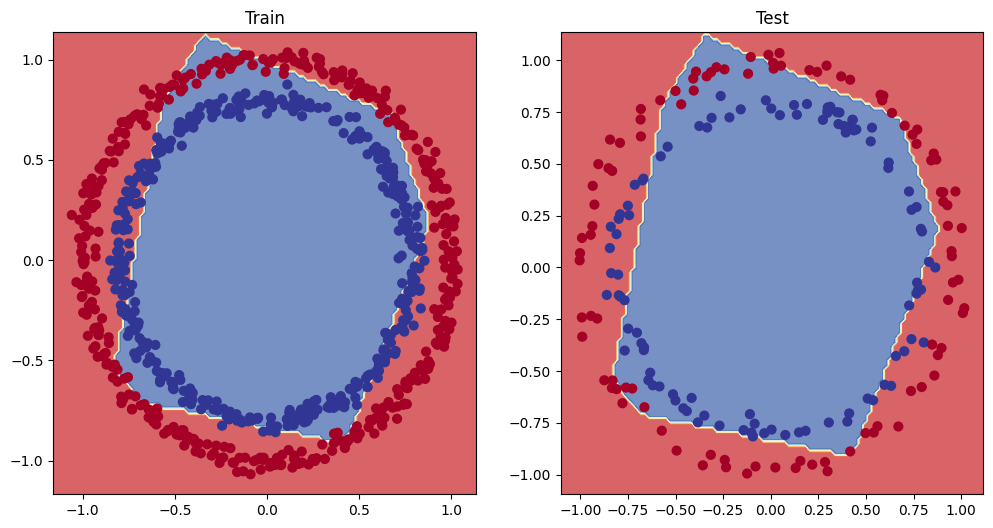

In [57]:
#plotdecsionBoundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

In [58]:
#replicating pytorch non linear functions with pure pytorch
A=torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

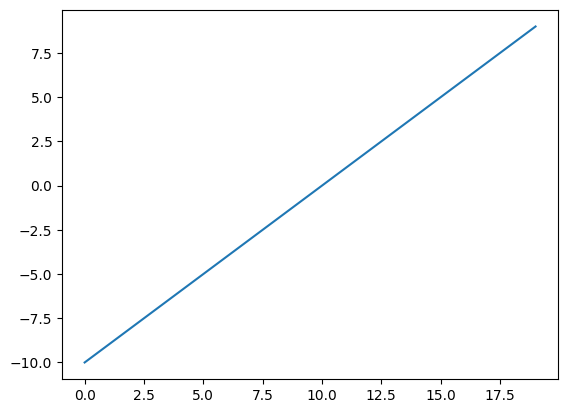

In [59]:
#visualize the tensor
plt.plot(A)

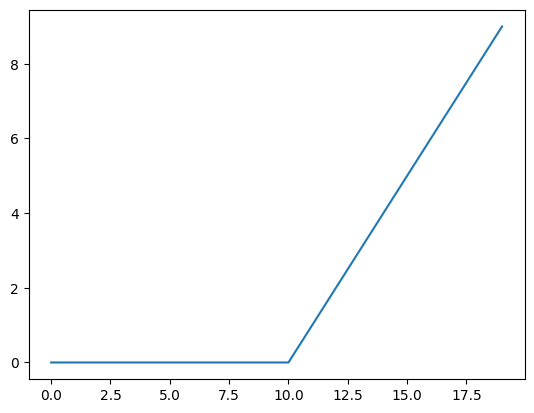

In [62]:
plt.plot(torch.relu(A))

In [63]:
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [64]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

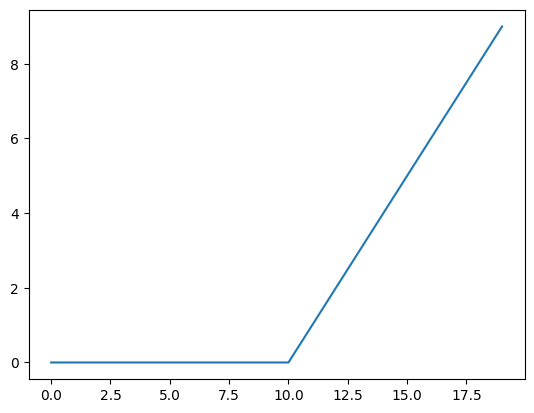

In [65]:
plt.plot(relu(A))

In [66]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

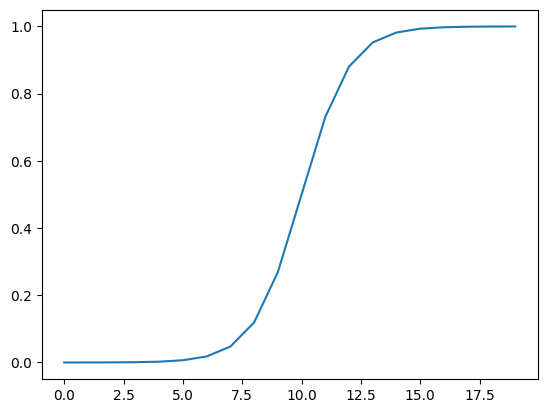

In [67]:
plt.plot(torch.sigmoid(A))

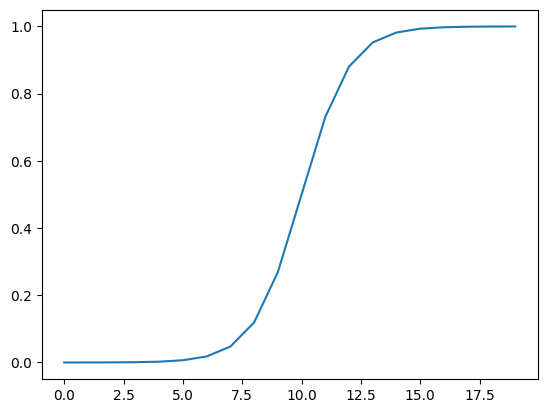

In [68]:
plt.plot(sigmoid(A))

In [196]:
#creating a toy multiclass dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

#1.create multi class data
X_blob,y_blob=make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)

#2.Turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float32)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#split into train and test
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

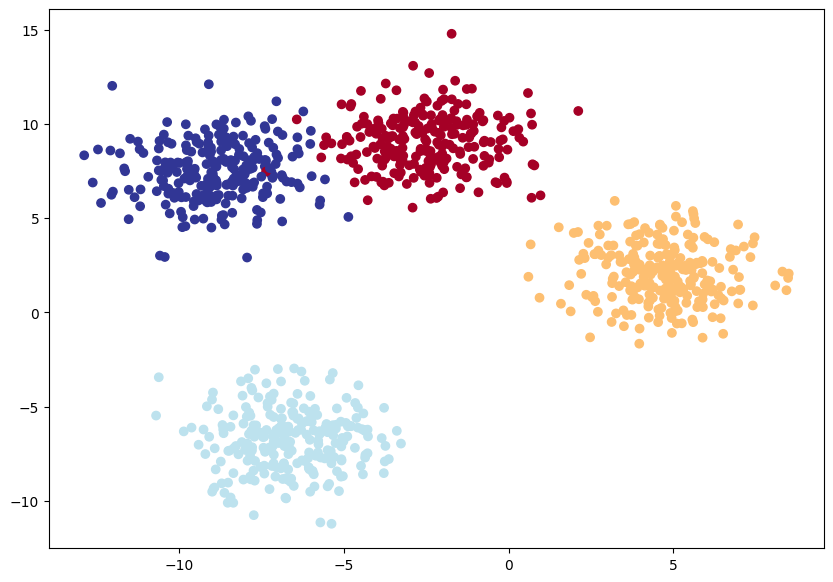

In [197]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [198]:
#Building a multi class classification model using pytorch
#create device agnostic code

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [199]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4=BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [207]:
#setting up loss function and optimizer for multiclass classification
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [208]:
#Get raw outputs of the model
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950],
        [-0.3673, -0.0935,  0.5180, -0.5787],
        [-0.3457,  0.2076,  0.1297, -0.9071],
        [ 0.1158, -0.1460,  0.1752, -0.1939],
        [-0.4845,  0.2289,  0.1336, -1.1274],
        [ 0.1284, -0.1145,  0.1691, -0.1944]])

In [209]:
y_pred_probs=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950]])
tensor([[0.2979, 0.3062, 0.2190, 0.1769],
        [0.2092, 0.2272, 0.3971, 0.1666],
        [0.1989, 0.3577, 0.3329, 0.1105],
        [0.3012, 0.3272, 0.2004, 0.1712],
        [0.2832, 0.2280, 0.2874, 0.2014]])


In [210]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [211]:
torch.max(y_pred_probs[0])

tensor(0.3062)

In [212]:
y_preds=torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
        1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2,
        1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2,
        1, 2, 1, 2, 2, 1, 1, 1])

In [213]:
#training loop
torch.manual_seed(42)

epochs=100

X_blob_train,y_blob_train=X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test=X_blob_test.to(device),y_blob_test.to(device)
model_4.train()
for epoch in range(epochs):
  y_logits=model_4(X_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy(y_blob_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
     y_test_logits=model_4(X_blob_test)
     y_test_pred=torch.softmax(y_test_logits,dim=1).argmax(dim=1)
     test_loss=loss_fn(y_test_logits,y_blob_test)
     test_acc=accuracy(y_blob_test,y_test_pred)

  if epoch%10==0:
      print(f"Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} |Test loss: {test_loss:.5f}, Test Accuracy:{test_acc:.5f}")

Epoch: 0 | loss: 1.32603, Acc: 33.00 |Test loss: 1.16789, Test Accuracy:50.50000
Epoch: 10 | loss: 0.56130, Acc: 77.50 |Test loss: 0.51789, Test Accuracy:76.50000
Epoch: 20 | loss: 0.37431, Acc: 81.12 |Test loss: 0.36443, Test Accuracy:82.00000
Epoch: 30 | loss: 0.27698, Acc: 94.00 |Test loss: 0.25921, Test Accuracy:97.50000
Epoch: 40 | loss: 0.14797, Acc: 98.62 |Test loss: 0.13505, Test Accuracy:100.00000
Epoch: 50 | loss: 0.09577, Acc: 99.00 |Test loss: 0.08503, Test Accuracy:99.50000
Epoch: 60 | loss: 0.07167, Acc: 99.00 |Test loss: 0.06172, Test Accuracy:99.50000
Epoch: 70 | loss: 0.05855, Acc: 99.12 |Test loss: 0.04892, Test Accuracy:99.50000
Epoch: 80 | loss: 0.05049, Acc: 99.12 |Test loss: 0.04102, Test Accuracy:99.50000
Epoch: 90 | loss: 0.04512, Acc: 99.12 |Test loss: 0.03573, Test Accuracy:99.50000


In [214]:
#make predictions
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test)

y_logits[:10]

tensor([[  3.5173,   9.1493,  -4.4478, -10.7253],
        [  3.3038, -11.2972,  -4.7749,   7.6802],
        [ -3.0950,  -0.9639,   6.5657,  -4.0219],
        [  2.1983,   5.5324,  -2.5983,  -6.4732],
        [  4.9600,   0.7375,  -6.8889,  -4.3687],
        [  3.7785, -13.4964,  -5.5557,   9.2136],
        [ -2.8146,  -0.5542,   6.2770,  -4.3717],
        [  4.3997,  -2.4249,  -6.1456,  -1.0955],
        [ -3.2904,  -3.3460,   6.6489,  -2.7213],
        [  4.5264,  -1.2334,  -6.2985,  -2.2611]])

In [216]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[3.5688e-03, 9.9643e-01, 1.2397e-06, 2.3282e-09],
        [1.2414e-02, 5.6593e-09, 3.8493e-06, 9.8758e-01],
        [6.3703e-05, 5.3665e-04, 9.9937e-01, 2.5212e-05],
        [3.4412e-02, 9.6530e-01, 2.8416e-04, 5.8982e-06],
        [9.8546e-01, 1.4448e-02, 7.0423e-06, 8.7546e-05],
        [4.3420e-03, 1.3655e-10, 3.8363e-07, 9.9566e-01],
        [1.1246e-04, 1.0783e-03, 9.9879e-01, 2.3702e-05],
        [9.9481e-01, 1.0810e-03, 2.6181e-05, 4.0852e-03],
        [4.8232e-05, 4.5627e-05, 9.9982e-01, 8.5211e-05],
        [9.9572e-01, 3.1382e-03, 1.9813e-05, 1.1230e-03]])

In [217]:
y_pred=torch.argmax(y_pred_probs,dim=1)
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

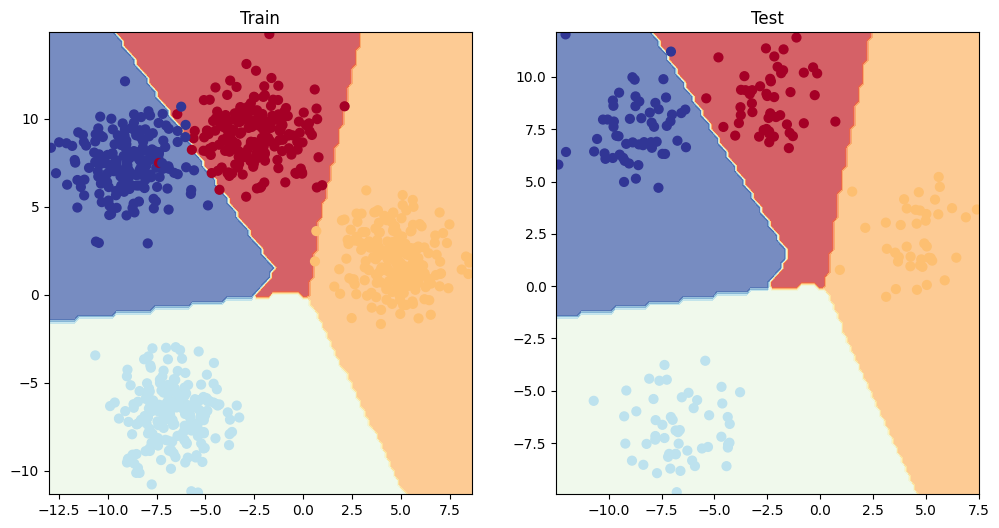

In [218]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)